### CS4622 Mini Kaggle Competition - Classification
#### Author: Sabine Hollatz

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.api as sm
from sklearn import preprocessing, metrics
from sklearn.model_selection import cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn import linear_model
from sklearn.linear_model import SGDClassifier
from sklearn.externals.six import StringIO 
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
# %tensorflow_version 2.x
import tensorflow as tf

import seaborn as sns

In [2]:

tf.__version__


'2.1.0'

In [0]:
# pip install --upgrade tensorflow


### Loading the Data and Preprocessiong

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
df_train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/stock_XY_train.csv')
df_train.head()

,Unnamed: 0,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",...,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Yr,Buy
0,4685,MGEN,2.538000e+06,-0.4125,2.472000e+06,6.600000e+04,1002000.0,10251000.0,1.125300e+07,-1.118700e+07,141000.0,-1.132800e+07,0.0,0.0,0.0,-1.132800e+07,0.0,-1.132800e+07,-21.02,-21.02,709385.0,539460.0,0.000,0.0260,-4.335,-4.4078,-4.463,-2.7664,-1.100300e+07,-1.118700e+07,-1.132800e+07,-4.4634,-4.4634,10832000.0,0.0,10832000.0,3.940000e+05,1.870000e+05,1.173400e+07,1.153000e+06,...,0.8547,13.8689,-1.0882,-0.2280,-0.9308,-0.9916,-0.6291,-0.7060,0.5994,0.5994,2.5853,2.5853,0.0000,-2.1170,-1.8322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6379,0.0447,0.5950,-0.5153,0.0000,1.8876,0.3534,Healthcare,15,0
1,3142,SO,1.846700e+10,0.0808,1.201200e+10,6.455000e+09,0.0,0.0,1.945000e+09,4.510000e+09,835000000.0,3.008000e+09,977000000.0,0.0,0.0,2.031000e+09,68000000.0,1.963000e+09,2.19,2.18,899812716.0,897000000.0,2.083,0.3495,0.332,0.2081,0.106,0.0250,6.136000e+09,3.843000e+09,2.031000e+09,0.1629,0.1100,710000000.0,0.0,710000000.0,1.947000e+09,1.969000e+09,5.864000e+09,5.486800e+10,...,2.7060,8.6557,0.0971,-5.9677,0.0188,0.1360,0.0169,0.1940,0.1649,0.1658,0.0228,0.0227,0.0348,-0.0463,-0.0906,0.0264,0.0078,-0.0003,0.0592,0.0957,-0.0200,0.0089,0.0106,-0.0507,0.0531,0.0354,0.0302,0.0394,0.0376,0.0361,0.0704,-0.1432,0.0881,0.0352,0.0636,0.0000,0.0000,Utilities,14,1
2,15877,ONDK,3.509500e+08,0.2047,1.991250e+08,1.518250e+08,53392000.0,94702000.0,1.661700e+08,-1.434500e+07,0.0,-1.153400e+07,0.0,-2811000.0,0.0,-1.153400e+07,0.0,-1.153400e+07,-0.16,-0.16,73635045.0,72890313.0,0.000,0.4326,-0.005,-0.0329,-0.033,0.5868,-1.583000e+06,-1.153400e+07,-1.434500e+07,-0.0329,-0.0329,114824000.0,0.0,114824000.0,0.000000e+00,0.000000e+00,9.586050e+08,2.357200e+07,...,22.0871,0.0000,-0.0440,-0.0584,0.3994,0.8610,0.8322,0.8610,0.8632,0.8632,0.0276,0.0276,0.0000,0.5657,0.6748,NaN,-0.0226,0.1698,NaN,0.0596,0.1367,NaN,0.0000,0.0000,NaN,NaN,-0.1527,NaN,0.0000,0.0000,0.0000,0.0000,-0.0639,-0.0175,-0.0826,-0.0935,-0.1790,Financial Services,17,0
3,6977,FFNW,3.392500e+07,-0.0320,0.000000e+00,3.392500e+07,0.0,19533000.0,1.987800e+07,1.404700e+07,0.0,1.404700e+07,4887000.0,0.0,0.0,9.160000e+06,0.0,9.160000e+06,0.67,0.67,14107868.0,13528393.0,0.240,1.0000,0.438,0.4141,0.270,0.4402,1.485600e+07,1.404700e+07,9.160000e+06,0.4141,0.2700,105711000.0,0.0,105711000.0,0.000000e+00,0.00

In [5]:
df_train = df_train.drop(['Unnamed: 0', 'Ticker', 'Yr'], axis=1)
df_train.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Buy
0,2.538000e+06,-0.4125,2.472000e+06,6.600000e+04,1002000.0,10251000.0,1.125300e+07,-1.118700e+07,141000.0,-1.132800e+07,0.0,0.0,0.0,-1.132800e+07,0.0,-1.132800e+07,-21.02,-21.02,709385.0,539460.0,0.000,0.0260,-4.335,-4.4078,-4.463,-2.7664,-1.100300e+07,-1.118700e+07,-1.132800e+07,-4.4634,-4.4634,10832000.0,0.0,10832000.0,3.940000e+05,1.870000e+05,1.173400e+07,1.153000e+06,0.000000e+00,0.0,...,3.4251,0.8547,13.8689,-1.0882,-0.2280,-0.9308,-0.9916,-0.6291,-0.7060,0.5994,0.5994,2.5853,2.5853,0.0000,-2.1170,-1.8322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6379,0.0447,0.5950,-0.5153,0.0000,1.8876,0.3534,Healthcare,0
1,1.846700e+10,0.0808,1.201200e+10,6.455000e+09,0.0,0.0,1.945000e+09,4.510000e+09,835000000.0,3.008000e+09,977000000.0,0.0,0.0,2.031000e+09,68000000.0,1.963000e+09,2.19,2.18,899812716.0,897000000.0,2.083,0.3495,0.332,0.2081,0.106,0.0250,6.136000e+09,3.843000e+09,2.031000e+09,0.1629,0.1100,710000000.0,0.0,710000000.0,1.947000e+09,1.969000e+09,5.864000e+09,5.486800e+10,0.000000e+00,743000000.0,...,9.8072,2.7060,8.6557,0.0971,-5.9677,0.0188,0.1360,0.0169,0.1940,0.1649,0.1658,0.0228,0.0227,0.0348,-0.0463,-0.0906,0.0264,0.0078,-0.0003,0.0592,0.0957,-0.0200,0.0089,0.0106,-0.0507,0.0531,0.0354,0.0302,0.0394,0.0376,0.0361,0.0704,-0.1432,0.0881,0.0352,0.0636,0.0000,0.0000,Utilities,1
2,3.509500e+08,0.2047,1.991250e+08,1.518250e+08,53392000.0,94702000.0,1.661700e+08,-1.434500e+07,0.0,-1.153400e+07,0.0,-2811000.0,0.0,-1.153400e+07,0.0,-1.153400e+07,-0.16,-0.16,73635045.0,72890313.0,0.000,0.4326,-0.005,-0.0329,-0.033,0.5868,-1.583000e+06,-1.153400e+07,-1.434500e+07,-0.0329,-0.0329,114824000.0,0.0,114824000.0,0.000000e+00,0.000000e+00,9.586050e+08,2.357200e+07,0.000000e+00,0.0,...,0.0000,22.0871,0.0000,-0.0440,-0.0584,0.3994,0.8610,0.8322,0.8610,0.8632,0.8632,0.0276,0.0276,0.0000,0.5657,0.6748,NaN,-0.0226,0.1698,NaN,0.0596,0.1367,NaN,0.0000,0.0000,NaN,NaN,-0.1527,NaN,0.0000,0.0000,0.0000,0.0000,-0.0639,-0.0175,-0.0826,-0.0935,-0.1790,Financial Services,0
3,3.392500e+07,-0.0320,0.000000e+00,3.392500e+07,0.0,19533000.0,1.987800e+07,1.404700e+07,0.0,1.404700e+07,4887000.0,0.0,0.0,9.160000e+06,0.0,9.160000e+06,0.67,0.67,14107868.0,13528393.0,0.240,1.0000,0.438,0.4141,0.270,0.4402,1.485600e+07,

In [6]:
df_val = pd.read_csv('/content/drive/My Drive/Colab Notebooks/data/stock_X_test.csv')
df_val.head()

,Unnamed: 0,Unnamed: 0.1,Ticker,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,...,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector,Yr
0,0,17685,CMCSA,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,3.380000e+09,131000000.0,0.000000e+00,1.173100e+10,0.0,1.173100e+10,2.56,2.53,4.549505e+09,4.549505e+09,0.917,1.0000,0.310,0.1974,0.124,0.1268,2.932900e+10,1.865300e+10,1.186200e+10,0.1599,0.1241,3.814000e+09,0.000000e+00,3.814000e+09,1.110400e+10,0.000000e+00,2.184800e+10,...,9.4801,3.6159,0.0000,0.1638,-2.7062,0.1115,0.0220,0.0550,-0.4840,-0.4700,-0.4674,-0.0266,-0.0305,0.9387,0.1428,0.2462,0.1327,0.1094,0.1107,0.1164,0.1456,0.1044,0.1928,0.1463,0.1579,0.0841,0.1019,0.1396,0.2558,0.1865,0.2348,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical,18
1,1,17686,KMI,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,5.870000e+08,310000000.0,0.000000e+00,1.609000e+09,128000000.0,1.481000e+09,0.66,0.66,2.207018e+09,2.216000e+09,0.725,0.4847,0.453,0.2908,0.105,0.1498,6.410000e+09,4.113000e+09,1.919000e+09,0.1553,0.1138,3.280000e+09,0.000000e+00,3.280000e+09,1.498000e+09,3.850000e+08,5.722000e+09,...,9.6022,2.8248,34.9666,0.0478,-1.3195,0.0564,0.0405,0.0751,53.8519,65.0000,65.0000,-0.0063,-0.0063,0.4500,0.0961,0.3841,NaN,-0.1402,-0.0104,NaN,-0.1057,-0.0215,NaN,-0.0881,0.8445,NaN,0.0376,-0.0182,0.0000,-0.1421,-0.2785,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy,18
2,2,17687,INTC,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,2.264000e+09,0.0,0.000000e+00,2.105300e+10,0.0,2.105300e+10,4.57,4.48,4.564000e+09,4.611000e+09,1.200,0.6173,0.456,0.3273,0.297,0.2011,3.227600e+10,2.319100e+10,2.105300e+10,0.3291,0.2972,3.019000e+09,8.631000e+09,1.165000e+10,6.722000e+09,7.253000e+09,2.878700e+10,...,11.4929,5.5264,9.9534,0.2824,-3.2923,0.1187,0.1203,0.2917,1.1928,1.2402,1.2513,-0.0191,-0.0277,0.1132,0.3312,0.3793,0.0876,0.0770,0.0959,0.1271,0.0883,0.1675,0.1719,0.1872,0.2377,0.0876,0.0665,0.0787,0.0815,0.0592,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology,18
3,3,17688,MU,3.039100e+10,0.4955,1.250000e+10,1.789100e+10,2.141000e+09,8.130000e+08,2.897000e+09,1.499400e+10,3.420000e+08,1.430300e+10,1.680000e+08,3000000.0,0.000000e+00,1.413500e+10,0

In [7]:
df_val = df_val.drop(['Unnamed: 0', 'Unnamed: 0.1', 'Ticker', 'Yr'], axis=1)
df_val.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,Days of Inventory on Hand,Receivables Turnover,Payables Turnover,Inventory Turnover,ROE,Capex per Share,Gross Profit Growth,EBIT Growth,Operating Income Growth,Net Income Growth,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Sector
0,9.450700e+10,0.1115,0.000000e+00,9.450700e+10,0.000000e+00,6.482200e+10,7.549800e+10,1.900900e+10,3.542000e+09,1.511100e+10,3.380000e+09,131000000.0,0.000000e+00,1.173100e+10,0.0,1.173100e+10,2.56,2.53,4.549505e+09,4.549505e+09,0.917,1.0000,0.310,0.1974,0.124,0.1268,2.932900e+10,1.865300e+10,1.186200e+10,0.1599,0.1241,3.814000e+09,0.000000e+00,3.814000e+09,1.110400e+10,0.000000e+00,2.184800e+10,4.443700e+10,1.676230e+11,7.883000e+09,...,0.0000,9.4801,3.6159,0.0000,0.1638,-2.7062,0.1115,0.0220,0.0550,-0.4840,-0.4700,-0.4674,-0.0266,-0.0305,0.9387,0.1428,0.2462,0.1327,0.1094,0.1107,0.1164,0.1456,0.1044,0.1928,0.1463,0.1579,0.0841,0.1019,0.1396,0.2558,0.1865,0.2348,0.2570,0.0000,0.3426,0.0722,0.7309,0.0000,0.1308,Consumer Cyclical
1,1.414400e+10,0.0320,7.288000e+09,6.856000e+09,0.000000e+00,6.010000e+08,3.062000e+09,3.794000e+09,1.917000e+09,2.196000e+09,5.870000e+08,310000000.0,0.000000e+00,1.609000e+09,128000000.0,1.481000e+09,0.66,0.66,2.207018e+09,2.216000e+09,0.725,0.4847,0.453,0.2908,0.105,0.1498,6.410000e+09,4.113000e+09,1.919000e+09,0.1553,0.1138,3.280000e+09,0.000000e+00,3.280000e+09,1.498000e+09,3.850000e+08,5.722000e+09,3.789700e+10,2.484500e+10,7.481000e+09,...,-19.2817,9.6022,2.8248,34.9666,0.0478,-1.3195,0.0564,0.0405,0.0751,53.8519,65.0000,65.0000,-0.0063,-0.0063,0.4500,0.0961,0.3841,NaN,-0.1402,-0.0104,NaN,-0.1057,-0.0215,NaN,-0.0881,0.8445,NaN,0.0376,-0.0182,0.0000,-0.1421,-0.2785,0.0345,-0.0920,-0.0024,0.0076,-0.0137,0.0000,-0.1265,Energy
2,7.084800e+10,0.1289,2.711100e+10,4.373700e+10,1.354300e+10,6.750000e+09,2.042100e+10,2.331600e+10,-1.260000e+08,2.331700e+10,2.264000e+09,0.0,0.000000e+00,2.105300e+10,0.0,2.105300e+10,4.57,4.48,4.564000e+09,4.611000e+09,1.200,0.6173,0.456,0.3273,0.297,0.2011,3.227600e+10,2.319100e+10,2.105300e+10,0.3291,0.2972,3.019000e+09,8.631000e+09,1.165000e+10,6.722000e+09,7.253000e+09,2.878700e+10,4.897600e+10,3.634900e+10,9.430000e+09,...,-97.6484,11.4929,5.5264,9.9534,0.2824,-3.2923,0.1187,0.1203,0.2917,1.1928,1.2402,1.2513,-0.0191,-0.0277,0.1132,0.3312,0.3793,0.0876,0.0770,0.0959,0.1271,0.0883,0.1675,0.1719,0.1872,0.2377,0.0876,0.0665,0.0787,0.0815,0.0592,0.0772,0.1989,0.0387,0.0382,0.1014,-0.0169,0.0390,-0.0942,Technology
3,3.039100e+10

In [8]:
df_train.dtypes

Revenue                 float64
Revenue Growth          float64
Cost of Revenue         float64
Gross Profit            float64
R&D Expenses            float64
                         ...   
Debt Growth             float64
R&D Expense Growth      float64
SG&A Expenses Growth    float64
Sector                   object
Buy                       int64
Length: 223, dtype: object

In [0]:
df_train['Sector'] = df_train['Sector'].astype('category')

In [10]:
sector_values_train = df_train['Sector'].unique()
sector_values_val = df_val['Sector'].unique()
sector_values_train

[Healthcare, Utilities, Financial Services, Basic Materials, Technology, ..., Consumer Cyclical, Energy, Real Estate, Consumer Defensive, Communication Services]
Length: 11
Categories (11, object): [Healthcare, Utilities, Financial Services, Basic Materials, ..., Energy,
                          Real Estate, Consumer Defensive, Communication Services]

In [11]:
# convert 11 Healthcare strings to 11 binary features
sector_binary_train = pd.get_dummies(df_train['Sector'])
sector_binary_val = pd.get_dummies(df_val['Sector'])
sector_binary_train

Sector,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
0,0,0,0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
12374,0,0,0,0,0,1,0,0,0,0,0
12375,0,0,0,0,0,1,0,0,0,0,0
12376,0,0,0,0,0,0,0,1,0,0,0
12377,0,0,0,0,0,0,1,0,0,0,0


In [12]:
# combine dataframes
df_train = pd.concat([df_train, sector_binary_train], axis=1)
df_train = df_train.drop('Sector', axis=1)
df_val = pd.concat([df_val, sector_binary_val], axis=1)
df_val = df_val.drop('Sector', axis=1)
df_train.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Buy,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
0,2.538000e+06,-0.4125,2.472000e+06,6.600000e+04,1002000.0,10251000.0,1.125300e+07,-1.118700e+07,141000.0,-1.132800e+07,0.0,0.0,0.0,-1.132800e+07,0.0,-1.132800e+07,-21.02,-21.02,709385.0,539460.0,0.000,0.0260,-4.335,-4.4078,-4.463,-2.7664,-1.100300e+07,-1.118700e+07,-1.132800e+07,-4.4634,-4.4634,10832000.0,0.0,10832000.0,3.940000e+05,1.870000e+05,1.173400e+07,1.153000e+06,0.000000e+00,0.0,...,0.5994,2.5853,2.5853,0.0000,-2.1170,-1.8322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.6379,0.0447,0.5950,-0.5153,0.0000,1.8876,0.3534,0,0,0,0,0,0,0,1,0,0,0,0
1,1.846700e+10,0.0808,1.201200e+10,6.455000e+09,0.0,0.0,1.945000e+09,4.510000e+09,835000000.0,3.008000e+09,977000000.0,0.0,0.0,2.031000e+09,68000000.0,1.963000e+09,2.19,2.18,899812716.0,897000000.0,2.083,0.3495,0.332,0.2081,0.106,0.0250,6.136000e+09,3.843000e+09,2.031000e+09,0.1629,0.1100,710000000.0,0.0,710000000.0,1.947000e+09,1.969000e+09,5.864000e+09,5.486800e+10,0.000000e+00,743000000.0,...,0.1658,0.0228,0.0227,0.0348,-0.0463,-0.0906,0.0264,0.0078,-0.0003,0.0592,0.0957,-0.0200,0.0089,0.0106,-0.0507,0.0531,0.0354,0.0302,0.0394,0.0376,0.0361,0.0704,-0.1432,0.0881,0.0352,0.0636,0.0000,0.0000,1,0,0,0,0,0,0,0,0,0,0,1
2,3.509500e+08,0.2047,1.991250e+08,1.518250e+08,53392000.0,94702000.0,1.661700e+08,-1.434500e+07,0.0,-1.153400e+07,0.0,-2811000.0,0.0,-1.153400e+07,0.0,-1.153400e+07,-0.16,-0.16,73635045.0,72890313.0,0.000,0.4326,-0.005,-0.0329,-0.033,0.5868,-1.583000e+06,-1.153400e+07,-1.434500e+07,-0.0329,-0.0329,114824000.0,0.0,114824000.0,0.000000e+00,0.000000e+00,9.586050e+08,2.357200e+07,0.000000e+00,0.0,...,0.8632,0.0276,0.0276,0.0000,0.5657,0.6748,NaN,-0.0226,0.1698,NaN,0.0596,0.1367,NaN,0.0000,0.0000,NaN,NaN,-0.1527,NaN,0.0000,0.0000,0.0000,0.0000,-0.0639,-0.0175,-0.0826,-0.0935,-0.1790,0,0,0,0,0,0,1,0,0,0,0,0
3,3.392500e+07,-0.0320,0.000000e+00,3.392500e+07,0.0,19533000.0,1.987800e+07,1.404700e+07,0.0,1.404700e+07,4887000.0,0.0,0.0,9.160000e+06,0.0,9.160000e+06,0.67,0.67,14107868.0,13528393.0,0.240,1.0000,0.438,0.4141,0.270,0.4402,1.485600e+07,1.404700e+07,9.160000e+06,0.4141,0.2700,105711000.0,0.0,105711000.0,0.000000e+00,0.000000e+00,1.135670e+08,1.770700e+07,0.000000e+00,100000000.0,...,-0.0563,-0.0826,-0.0807,0.2000,-0.1006,-0.1873,NaN,0.0000,

In [13]:
df_train.dtypes

Revenue            float64
Revenue Growth     float64
Cost of Revenue    float64
Gross Profit       float64
R&D Expenses       float64
                    ...   
Healthcare           uint8
Industrials          uint8
Real Estate          uint8
Technology           uint8
Utilities            uint8
Length: 233, dtype: object

In [14]:
df_train.isna().sum()

Revenue             796
Revenue Growth     1379
Cost of Revenue    1103
Gross Profit        794
R&D Expenses       1353
                   ... 
Healthcare            0
Industrials           0
Real Estate           0
Technology            0
Utilities             0
Length: 233, dtype: int64

In [0]:
# split predictors and response variable
df_X_train = df_train.drop('Buy', axis=1)
df_y_train = df_train['Buy']

In [0]:
# get quantitative features to fill missing values with the feature mean. No missing values in qualitative 
# feature 'Sector'.
columns_quant = list(df_X_train.columns.values)

df_X_train[columns_quant] = df_X_train[columns_quant].transform(lambda x: x.fillna(x.mean()))
df_val[columns_quant] = df_val[columns_quant].transform(lambda x: x.fillna(x.mean()))

In [17]:
df_X_train.isna().sum()

Revenue            0
Revenue Growth     0
Cost of Revenue    0
Gross Profit       0
R&D Expenses       0
                  ..
Healthcare         0
Industrials        0
Real Estate        0
Technology         0
Utilities          0
Length: 232, dtype: int64

In [18]:
df_X_train.isnull().sum()

Revenue            0
Revenue Growth     0
Cost of Revenue    0
Gross Profit       0
R&D Expenses       0
                  ..
Healthcare         0
Industrials        0
Real Estate        0
Technology         0
Utilities          0
Length: 232, dtype: int64

In [19]:
df_X_train.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
0,2.538000e+06,-0.4125,2.472000e+06,6.600000e+04,1002000.0,10251000.0,1.125300e+07,-1.118700e+07,141000.0,-1.132800e+07,0.0,0.0,0.0,-1.132800e+07,0.0,-1.132800e+07,-21.02,-21.02,709385.0,539460.0,0.000,0.0260,-4.335,-4.4078,-4.463,-2.7664,-1.100300e+07,-1.118700e+07,-1.132800e+07,-4.4634,-4.4634,10832000.0,0.0,10832000.0,3.940000e+05,1.870000e+05,1.173400e+07,1.153000e+06,0.000000e+00,0.0,...,0.5994,0.5994,2.5853,2.5853,0.0000,-2.1170,-1.8322,0.020848,0.027129,0.04013,0.038126,0.045132,0.061041,0.028911,0.057021,0.067262,0.033689,0.040816,0.051744,-0.022484,0.00509,0.016794,-0.6379,0.0447,0.5950,-0.5153,0.0000,1.8876,0.3534,0,0,0,0,0,0,1,0,0,0,0
1,1.846700e+10,0.0808,1.201200e+10,6.455000e+09,0.0,0.0,1.945000e+09,4.510000e+09,835000000.0,3.008000e+09,977000000.0,0.0,0.0,2.031000e+09,68000000.0,1.963000e+09,2.19,2.18,899812716.0,897000000.0,2.083,0.3495,0.332,0.2081,0.106,0.0250,6.136000e+09,3.843000e+09,2.031000e+09,0.1629,0.1100,710000000.0,0.0,710000000.0,1.947000e+09,1.969000e+09,5.864000e+09,5.486800e+10,0.000000e+00,743000000.0,...,0.1649,0.1658,0.0228,0.0227,0.0348,-0.0463,-0.0906,0.026400,0.007800,-0.00030,0.059200,0.095700,-0.020000,0.008900,0.010600,-0.050700,0.053100,0.035400,0.030200,0.039400,0.03760,0.036100,0.0704,-0.1432,0.0881,0.0352,0.0636,0.0000,0.0000,0,0,0,0,0,0,0,0,0,0,1
2,3.509500e+08,0.2047,1.991250e+08,1.518250e+08,53392000.0,94702000.0,1.661700e+08,-1.434500e+07,0.0,-1.153400e+07,0.0,-2811000.0,0.0,-1.153400e+07,0.0,-1.153400e+07,-0.16,-0.16,73635045.0,72890313.0,0.000,0.4326,-0.005,-0.0329,-0.033,0.5868,-1.583000e+06,-1.153400e+07,-1.434500e+07,-0.0329,-0.0329,114824000.0,0.0,114824000.0,0.000000e+00,0.000000e+00,9.586050e+08,2.357200e+07,0.000000e+00,0.0,...,0.8632,0.8632,0.0276,0.0276,0.0000,0.5657,0.6748,0.020848,-0.022600,0.16980,0.038126,0.059600,0.136700,0.028911,0.000000,0.000000,0.033689,0.040816,-0.152700,-0.022484,0.00000,0.000000,0.0000,0.0000,-0.0639,-0.0175,-0.0826,-0.0935,-0.1790,0,0,0,0,0,1,0,0,0,0,0
3,3.392500e+07,-0.0320,0.000000e+00,3.392500e+07,0.0,19533000.0,1.987800e+07,1.404700e+07,0.0,1.404700e+07,4887000.0,0.0,0.0,9.160000e+06,0.0,9.160000e+06,0.67,0.67,14107868.0,13528393.0,0.240,1.0000,0.438,0.4141,0.270,0.4402,1.485600e+07,1.404700e+07,9.160000e+06,0.4141,0.2

In [21]:
# normalize quantitative features
min_max_scaler = preprocessing.MinMaxScaler()
df_X_train_scaled = df_X_train.copy(deep=True)
df_val_scaled = df_val.copy(deep=True)

for attr in columns_quant:
    df_X_train_scaled[attr] = min_max_scaler.fit_transform(df_X_train_scaled[attr].values.reshape(-1,1))
    df_val_scaled[attr] = min_max_scaler.fit_transform(df_val_scaled[attr].values.reshape(-1,1))
df_X_train_scaled.head()

,Revenue,Revenue Growth,Cost of Revenue,Gross Profit,R&D Expenses,SG&A Expense,Operating Expenses,Operating Income,Interest Expense,Earnings before Tax,Income Tax Expense,Net Income - Non-Controlling int,Net Income - Discontinued ops,Net Income,Preferred Dividends,Net Income Com,EPS,EPS Diluted,Weighted Average Shs Out,Weighted Average Shs Out (Dil),Dividend per Share,Gross Margin,EBITDA Margin,EBIT Margin,Profit Margin,Free Cash Flow margin,EBITDA,EBIT,Consolidated Income,Earnings Before Tax Margin,Net Profit Margin,Cash and cash equivalents,Short-term investments,Cash and short-term investments,Receivables,Inventories,Total current assets,"Property, Plant & Equipment Net",Goodwill and Intangible Assets,Long-term investments,...,EPS Growth,EPS Diluted Growth,Weighted Average Shares Growth,Weighted Average Shares Diluted Growth,Dividends per Share Growth,Operating Cash Flow growth,Free Cash Flow growth,10Y Revenue Growth (per Share),5Y Revenue Growth (per Share),3Y Revenue Growth (per Share),10Y Operating CF Growth (per Share),5Y Operating CF Growth (per Share),3Y Operating CF Growth (per Share),10Y Net Income Growth (per Share),5Y Net Income Growth (per Share),3Y Net Income Growth (per Share),10Y Shareholders Equity Growth (per Share),5Y Shareholders Equity Growth (per Share),3Y Shareholders Equity Growth (per Share),10Y Dividend per Share Growth (per Share),5Y Dividend per Share Growth (per Share),3Y Dividend per Share Growth (per Share),Receivables growth,Inventory Growth,Asset Growth,Book Value per Share Growth,Debt Growth,R&D Expense Growth,SG&A Expenses Growth,Basic Materials,Communication Services,Consumer Cyclical,Consumer Defensive,Energy,Financial Services,Healthcare,Industrials,Real Estate,Technology,Utilities
0,0.000346,0.000293,0.001927,0.026966,0.004875,0.000336,0.017701,0.109884,0.033930,0.179635,0.465028,0.197957,0.679831,0.084306,0.014960,0.084306,0.926951,0.938946,0.000007,0.000005,0.000000,0.946201,0.981371,0.978756,0.984548,0.920402,0.058629,0.073554,0.084306,0.977891,0.982357,0.000015,0.0,0.000011,9.493976e-07,4.379155e-07,0.000010,0.000001,0.000000,0.000057,...,0.759988,0.759988,0.000232,1.061264e-06,0.002677,0.164840,0.269007,0.371623,0.246853,0.023155,0.320676,0.273652,0.116187,0.445127,0.201829,0.121777,0.236164,0.131833,0.048295,0.552612,0.252466,0.184640,0.000020,0.004791,0.002503,0.360157,0.000193,0.002944,0.007499,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.010472,0.000305,0.009668,0.040556,0.004831,0.000280,0.023917,0.135588,0.059516,0.208035,0.465644,0.197957,0.679831,0.092298,0.046932,0.092032,0.926951,0.938946,0.008538,0.008511,0.002386,0.950318,0.981818,0.979261,0.984987,0.920723,0.083387,0.088813,0.092298,0.978396,0.982859,0.000963,0.0,0.000719,4.691566e-03,4.610993e-03,0.004829,0.059200,0.000000,0.000802,...,0.759833,0.759833,0.000066,3.027235e-07,0.002770,0.164899,0.269166,0.373644,0.242207,0.022255,0.329124,0.286893,0.107313,0.436470,0.192966,0.108317,0.242298,0.131048,0.047269,0.587597,0.260631,0.188146,0.000058,0.003930,0.001708,0.360207,0.000205,0.001723,0.006418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.000537,0.000308,0.002054,0.027286,0.007180,0.000790,0.018199,0.109866,0.033926,0.179633,0.465028,0.197606,0.679831,0.084305,0.014960,0.084305,0.926951,0.938946,0.000699,0.000692,0.000000,0.951376,0.981785,0.979234,0.984973,0.920788,0.058667,0.073553,0.084294,0.978375,0.982843,0.000156,0.0,0.000116,0.000000e+00,0.000000e+00,0.000789,0.000025,0.000000,0.000057,...,0.760082,0.760082,0.000066,3.041739e-07,0.002677,0.164916,0.269235,0.371623,0.234901,0.026042,0.320676,0.277440,0.124472,0.445127,0.190942,0.114102,0.236164,0.131833,0.038559,0.552612,0.251187,0.181590,0.000054,0.004586,0.001469,0.360203,0.000178,0.001662,0.005871,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,0.000363,0.000302,0.001925,0.027037,0.004831,0.000386,0.017729,0.110027,0.033926,0.179873,0.465031,0.197957,0.679831,0.084386,0.014960,0.084386,0.926951,0.938946,0.000134,0.000128,0.000275,0.958597,0.981828,0.9792

In [0]:
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,10))
# ax.boxplot(X_train[columns_quant[:56]])
# # ax[1].boxplot(X_train[columns_quant[56:111]], labels=columns_quant[56:111])
# # ax[2].boxplot(X_train[columns_quant[111:167]], labels=columns_quant[111:167])
# # ax[3].boxplot(X_train[columns_quant[167:]], labels=columns_quant[167:])
# plt.xticks(rotation=90);

In [0]:
def outlierCheck(df, attr):
    outlier_indices = []
    outlier_values = []
    inlier_indices = []
    q1 = df[attr].quantile(.25)
    q3 = df[attr].quantile(.75)
    iqr = q3 - q1
    
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    
    for index, row in df.iterrows():
        if row[attr] > upper_bound:
            outlier_indices.append(index)
            outlier_values.append(row[attr])
        elif row[attr] < lower_bound:
            outlier_indices.append(index)
            outlier_values.append(row[attr])
        else:
            inlier_indices.append(index)
    return inlier_indices, outlier_indices, outlier_values

In [0]:
# outliers = []
# for feature in columns_quant:
#     inlier, outlier, _ = outlierCheck(df_X_train, feature)
#     outliers = outliers + outlier
#     # print("In train_X feature {} are {} outliers".format(feature, len(outlier)))
# # print("")




In [0]:
# outliers = set(outliers)
# print("A total of {} outliers ar in all features detected".format(len(outliers)))
# print(outliers)

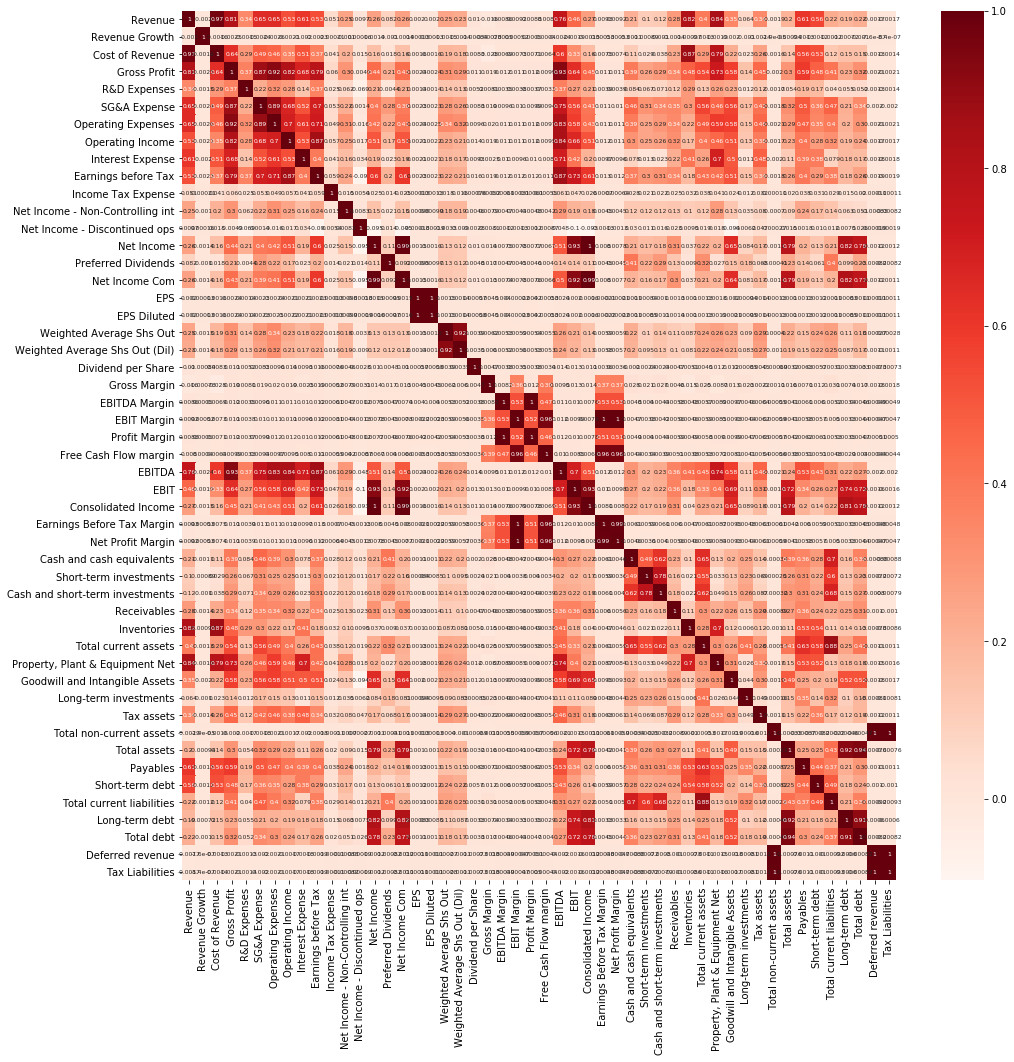

In [25]:
plt.figure(figsize=(17,17))
cor = df_X_train.iloc[:,:50].corr()
sns.heatmap(cor, annot=True, annot_kws={"size":6}, cmap=plt.cm.Reds)
plt.show()

In [27]:
X_train = np.array(df_X_train)
X_train_scaled = np.array(df_X_train_scaled)
y_train = np.array(df_y_train)
X_val = np.array(df_val)
X_val_scaled = np.array(df_val_scaled)
# print(type(X_train))

<class 'numpy.ndarray'>


All data points seem to have at least 1 feature value that is an outlier. Under these circumstances, outliers cannot be removed.

### Training Binary Classifiers

#### Stochastic Gradient Descent classifier

In [28]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=7)
sgd_clf.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=7, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [29]:
cross_val_score(sgd_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.51655897, 0.44870759, 0.4503231 , 0.44749596, 0.44040404])

In [30]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=5)
metrics.confusion_matrix(y_train, y_train_pred)

array([[2541, 3437],
       [3239, 3162]])

In [31]:
pred_sgd = sgd_clf.predict(X_val_scaled)
print(pred_sgd)

[0 0 0 ... 0 0 0]


In [32]:
# SGD Classifier applies Stochastic Gradient Descent to train a linear SVM classifier
sgd_clf_scaled = SGDClassifier(random_state=7)
sgd_clf_scaled.fit(X_train_scaled, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=7, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [33]:
cross_val_score(sgd_clf_scaled, X_train_scaled, y_train, cv=5, scoring="accuracy")

array([0.52786753, 0.53069467, 0.53271405, 0.52827141, 0.55474747])

In [34]:
pred_sgd_scaled = sgd_clf_scaled.predict(X_val_scaled)
print(pred_sgd_scaled)

[0 0 0 ... 0 0 0]


The decision boundary does not seem to be linear.

In [35]:
# logistic regression
log_reg = linear_model.LogisticRegressionCV(solver='lbfgs', max_iter=10000).fit(X_train_scaled, y_train)
y_hat_log_reg = cross_val_predict(log_reg, X_train_scaled, y_train, cv=5)
metrics.confusion_matrix(y_train, y_hat_log_reg)

array([[2675, 3303],
       [2077, 4324]])

In [36]:
cross_val_score(log_reg, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.56409014, 0.56689287, 0.5618032 ])

In [37]:
pred_log_reg = log_reg.predict(X_val_scaled)
print(pred_log_reg)

[0 0 0 ... 0 0 0]


In [0]:
# neural network
model_01 = tf.keras.Sequential()
model_01.add(tf.keras.layers.Dense(512, activation=tf.nn.relu, input_shape=[232]))
model_01.add(tf.keras.layers.Dense(1, activation="sigmoid"))

In [39]:
opt = tf.keras.optimizers.SGD(learning_rate=0.1)
model_01.compile(loss='binary_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model_01.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               119296    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 119,809
Trainable params: 119,809
Non-trainable params: 0
_________________________________________________________________


In [40]:
history_01 = model_01.fit(X_train_scaled, y_train, epochs=20)

Train on 12379 samples
Epoch 1/20
12379/12379 [==============================] - 2s 130us/sample - loss: 0.6956 - accuracy: 0.5322
Epoch 2/20
12379/12379 [==============================] - 1s 87us/sample - loss: 0.6879 - accuracy: 0.5476
Epoch 3/20
12379/12379 [==============================] - 1s 82us/sample - loss: 0.6857 - accuracy: 0.5534
Epoch 4/20
12379/12379 [==============================] - 1s 87us/sample - loss: 0.6855 - accuracy: 0.5512
Epoch 5/20
12379/12379 [==============================] - 1s 82us/sample - loss: 0.6844 - accuracy: 0.5606
Epoch 6/20
12379/12379 [==============================] - 1s 83us/sample - loss: 0.6852 - accuracy: 0.5559
Epoch 7/20
12379/12379 [==============================] - 1s 80us/sample - loss: 0.6847 - accuracy: 0.5563
Epoch 8/20
12379/12379 [==============================] - 1s 80us/sample - loss: 0.6845 - accuracy: 0.5584
Epoch 9/20
12379/12379 [==============================] - 1s 82us/sample - loss: 0.6837 - accuracy: 0.5573
Epoch 10/20
1

In [41]:
pred_model_01 = model_01.predict(X_val_scaled)
print(pred_model_01)

[[0.49804685]
 [0.3830451 ]
 [0.51181614]
 ...
 [0.5490774 ]
 [0.47076395]
 [0.568825  ]]


Hyperparameter Tuning for model_01


In [0]:
# hyperparameter tuning
def build_model(num_hidden=1, num_neurons=30, learning_rate=3e-3, input_shape=[232]):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.InputLayer(input_shape=input_shape))
  for layer in range(num_hidden):
    model.add(tf.keras.layers.Dense(num_neurons, activation="relu"))
  model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
  optimizer = tf.keras.optimizers.SGD(lr=learning_rate)
  model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
  return model



In [0]:
keras_cls = tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [44]:
param_distribs = {
    'num_hidden': [0,1,2,3],
    'num_neurons': [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'learning_rate': [3e-4, 1e-4, 9e-3, 7e-3, 5e-3, 3e-3, 1e-3, 9e-2, 7e-2, 5e-2, 3e-2]
}

rnd_search_cv = RandomizedSearchCV(keras_cls, param_distribs, n_iter=10, cv=3)
rnd_search_cv.fit(X_train_scaled, y_train, epochs=20, verbose=0)

4126/4126 [==============================] - 0s 80us/sample - loss: 0.6932 - accuracy: 0.5208


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7f5590508e10>,
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'learning_rate': [0.0003, 0.0001, 0.009,
                                                          0.007, 0.005, 0.003,
                                                          0.001, 0.09, 0.07,
                                                          0.05, 0.03],
                                        'num_hidden': [0, 1, 2, 3],
                                        'num_neurons': [1, 10, 20, 30, 40, 50,
                                                        60, 70, 80, 90, 100]},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=0)

In [45]:
print(rnd_search_cv.best_params_)
print(rnd_search_cv.best_score_)
model = rnd_search_cv.best_estimator_.model

{'num_neurons': 70, 'num_hidden': 2, 'learning_rate': 0.009}
0.5558614730834961


In [0]:
history = model.fit(X_train_scaled, y_train, epochs=1000, verbose=0)

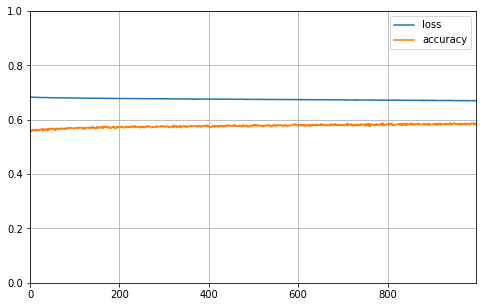

In [47]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [96]:
pred_nn = model.predict(df_val_scaled)
from itertools import chain
pred_nn = list(chain.from_iterable(pred_nn))
print(pred_nn[:6])

[0.02790849, 0.087928295, 0.047393378, 0.0733827, 0.1689845, 0.04123293]


In [55]:
# SVM classifier
poly_kernel_svm_clf = Pipeline([
                                ("scaler", StandardScaler()),
                                ("svm_clf", SVC(kernel="poly", degree=3, coef0=1, C=5))
])
poly_kernel_svm_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=5, break_ties=False, cache_size=200, class_weight=None,
                     coef0=1, decision_function_shape='ovr', degree=3,
                     gamma='scale', kernel='poly', max_iter=-1,
                     probability=False, random_state=None, shrinking=True,
                     tol=0.001, verbose=False))],
         verbose=False)

In [56]:
cross_val_score(poly_kernel_svm_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.57673667, 0.57552504, 0.57189015, 0.58562197, 0.57575758])

In [57]:
pred_poly_svm = poly_kernel_svm_clf.predict(X_val)
print(pred_poly_svm)

[1 1 1 ... 1 1 1]


In [58]:
# Gaussian RBF Kernel
rbf_kernel_svm_clf = Pipeline([
                               ("scaler", StandardScaler()),
                               ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.001))
])
rbf_kernel_svm_clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svm_clf',
                 SVC(C=0.001, break_ties=False, cache_size=200,
                     class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=5,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

In [59]:
cross_val_score(rbf_kernel_svm_clf, X_train, y_train, cv=5, scoring="accuracy")

array([0.57673667, 0.57552504, 0.57189015, 0.58562197, 0.57575758])

In [60]:
pred_rbf_svm = rbf_kernel_svm_clf.predict(X_val)
print(pred_rbf_svm)

[1 1 1 ... 1 1 1]


In [0]:
# data = {"Unnamed: 0": df_val.index.values, 'Buy': pred_nn}
# df_pred_nn = pd.DataFrame.from_dict(data)
# df_pred_nn = df_pred_nn.astype({'Unnamed: 0':'int32'})
# df_pred_nn.head()

In [61]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) +1
print(d)

1


In [70]:
# Kernel PCA makes it possible to perform complex nonlinear projections for dimensionality reduction.
# Use grid search to select the kernel and hyperparameters that lead to the best classification performance.
clf = Pipeline([
                ("kpca", KernelPCA(n_components=1)),
                ("log_reg", linear_model.LogisticRegression())
])
param_grid = [{
    "kpca__gamma": np.linspace(0.03, 0.05, 10),
    "kpca__kernel": ["rbf", "sigmoid"]
}] 

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('kpca',
                                        KernelPCA(alpha=1.0, coef0=1,
                                                  copy_X=True, degree=3,
                                                  eigen_solver='auto',
                                                  fit_inverse_transform=False,
                                                  gamma=None, kernel='linear',
                                                  kernel_params=None,
                                                  max_iter=None, n_components=1,
                                                  n_jobs=None,
                                                  random_state=None,
                                                  remove_zero_eig=False,
                                                  tol=0)),
                                       ('log_reg',
                                 

In [71]:
print(grid_search.best_params_)

{'kpca__gamma': 0.03, 'kpca__kernel': 'sigmoid'}


In [72]:
cross_val_score(grid_search, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.53089411, 0.52835676, 0.5266602 ])

In [73]:
pred_grid_search = grid_search.predict(X_val)
print(pred_grid_search)

[0 0 0 ... 0 0 0]


In [85]:
# Dimensionality reduction using PCA
pca = PCA(n_components=0.95)
X_train_scaled_reduced = pca.fit_transform(X_train_scaled)
print(X_train_scaled_reduced.shape)

(12379, 14)


In [86]:
sgd_clf_scaled_pca = SGDClassifier(random_state=7)
sgd_clf_scaled_pca.fit(X_train_scaled_reduced, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=7, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [87]:
cross_val_score(sgd_clf_scaled_pca, X_train, y_train, cv=3, scoring="accuracy")

array([0.46837897, 0.44789142, 0.45273873])

In [0]:
model_pca = build_model(2, 70, 0.009, [14])
history_pca = model_pca.fit(X_train_scaled_reduced, y_train, epochs=100, verbose=0)

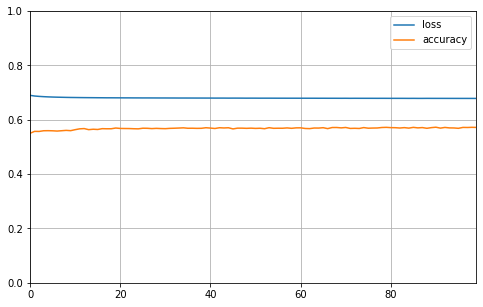

In [91]:
pd.DataFrame(history_pca.history).plot(figsize=(8,5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [93]:
log_reg_pca = linear_model.LogisticRegressionCV(solver='lbfgs', max_iter=10000).fit(X_train_scaled_reduced, y_train)
y_hat_log_reg_pca = cross_val_predict(log_reg_pca, X_train_scaled_reduced, y_train, cv=5)
metrics.confusion_matrix(y_train, y_hat_log_reg_pca)

array([[2667, 3311],
       [2068, 4333]])

In [95]:
cross_val_score(log_reg_pca, X_train_scaled_reduced, y_train, cv=3, scoring="accuracy")

array([0.56530167, 0.5625303 , 0.56568105])